In [257]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import wave
import IPython
import arlpy
import control
import pyroomacoustics as pra
from shlnb.shlnb import *

### Creating sample time-delayed sinusoidal waveforms for testing 'find_delays' function

In [339]:
s_rate = 44100
waveform1 = np.sin(np.linspace(0,10*np.pi,1000))
waveform2 = np.sin(np.linspace(0.1,10*np.pi+0.1,1000))
waveform_data = np.array([waveform1, waveform2])
waveform_data_t = waveform_data.transpose()

print(waveform_data,"\n", "waveform_data has array shape:", waveform_data.shape, "\n")
print(waveform_data_t, "\n", "Waveform_data_1 has array shape:" ,waveform_data_1.shape, "\n")

waveform_data.shape

[[ 0.00000000e+00  3.14421909e-02  6.28532900e-02 ... -6.28532900e-02
  -3.14421909e-02 -1.22464680e-15]
 [ 9.98334166e-02  1.31069167e-01  1.62175309e-01 ...  3.70967383e-02
   6.84989453e-02  9.98334166e-02]] 
 waveform_data has array shape: (2, 1000) 

[[ 0.00000000e+00  9.98334166e-02]
 [ 3.14421909e-02  1.31069167e-01]
 [ 6.28532900e-02  1.62175309e-01]
 ...
 [-6.28532900e-02  3.70967383e-02]
 [-3.14421909e-02  6.84989453e-02]
 [-1.22464680e-15  9.98334166e-02]] 
 Waveform_data_1 has array shape: (1000, 2) 



(2, 1000)

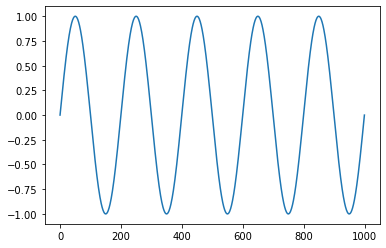

In [330]:
plt.plot(waveform1)

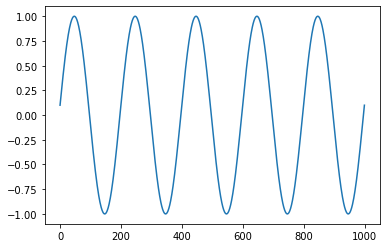

In [331]:
plt.plot(waveform2)

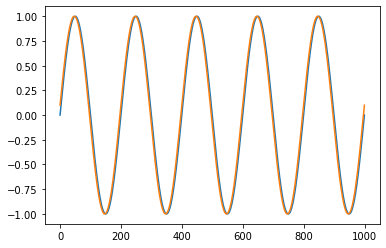

In [332]:
plt.plot(waveform_data_t)

In [371]:
print(waveform_data_t.shape)
delays = find_delays(waveform_data_t) # This outputs average time delay of each waveform in samples
delays_t = delays/s_rate # Converts delays in samples to delays in seconds
print(delays)
print(delays_t)

(1000, 2)
[0.   3.25]
[0.00000000e+00 6.77083333e-05]


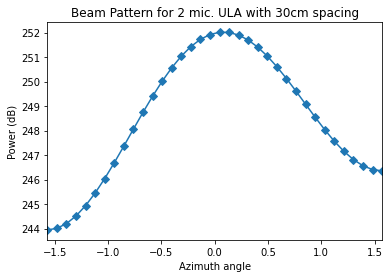

In [334]:
sens_pos = np.array([-0.15, 0.15]) # Defining distance of microphones from azimuth angle = 0 in metres
beam_pattern = [] # Creating empty array to store beam battern data
angles_tested = list(np.linspace(-np.pi/2,np.pi/2,36)) # Defining angle range tested and number of increments
for theta in angles_tested:
    steering_delay = arlpy.bf.steering_plane_wave(sens_pos,343,theta) # Computing steering delays for incoming planar wavefront for each sensor
    y = arlpy.bf.broadband(waveform_data,s_rate,1000,steering_delay) # Performs beamforming in frequency domain and outputs steering direction
    beam_pattern.append(np.mean(y**2)) # Unsure why we raise beam pattern by a factor of 2 here
beam_pattern = np.array(beam_pattern)

plt.plot(angles_tested,control.mag2db(beam_pattern),'-D') # Converts magnitude to decibels (dB = 20log10(magnitude))
plt.xlim((-np.pi/2,np.pi/2))
plt.xlabel('Azimuth angle')
plt.ylabel('Power (dB)')
plt.title("Beam Pattern for 2 mic. ULA with 30cm spacing")
plt.show()

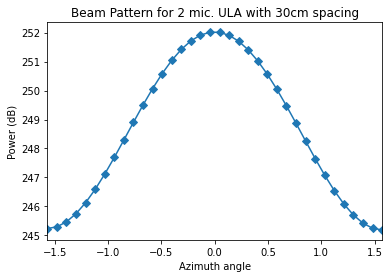

In [335]:
sens_pos = np.array([-0.15, 0.15]) # Defining distance of microphones from azimuth angle = 0 in metres
beam_pattern = [] # Creating empty array to store beam battern data
angles_tested = list(np.linspace(-np.pi/2,np.pi/2,36)) # Defining angle range tested and number of increments
for theta in angles_tested:
    steering_delay = arlpy.bf.steering_plane_wave(sens_pos,343,theta) - delays_t # Computing steering delays for incoming planar wavefront for each sensor
    y = arlpy.bf.broadband(waveform_data,s_rate,1000,steering_delay) # Performs beamforming in frequency domain and outputs steering direction
    beam_pattern.append(np.mean(y**2)) # Unsure why we raise beam pattern by a factor of 2 here
beam_pattern = np.array(beam_pattern)

plt.plot(angles_tested,control.mag2db(beam_pattern),'-D') # Converts magnitude to decibels (dB = 20log10(magnitude))
plt.xlim((-np.pi/2,np.pi/2))
plt.xlabel('Azimuth angle')
plt.ylabel('Power (dB)')
plt.title("Beam Pattern for 2 mic. ULA with 30cm spacing")
plt.show()

## Applying find_delays function on synthetically created PDM audio

In [391]:
signal = wave.open("2kHz5sStereo.wav") # Synthetically produced PDM stereo by time-shifting in audacity by 0.001s emulating inter-microphone distance of ~30cm 
s_rate = signal.getframerate() # Sampling rate (Hz)
n_frames = signal.getnframes() # Total number of frames in audio file
n_channels = signal.getnchannels() # Number of channels in audio file
print("Sampling rate is:", s_rate)
print("Number of frames in audio file:", n_frames)
print("Number of channels in audio file:", n_channels)

Sampling rate is: 44100
Number of frames in audio file: 220544
Number of channels in audio file: 2


In [392]:
data = signal.readframes(-1) # Accessing audio data, "-1" input accesses ALL frames
w_signal = np.frombuffer(data,np.int16) # Original .wav file data is in binary, this converts it into integers
print(w_signal) # Currently samples are in the form: L R L R, we need to reshape the array

[    0     0  4612 ... -8846    -2 -4615]


In [393]:
w_signal.shape = -1,2 # Restructures data into 2 columns: 1 for channel L and 1 for channel R, "-1" = Do this for all data, "2" = 2 columns
print(w_signal)

[[     0      0]
 [  4612      0]
 [  8849      0]
 ...
 [    -1 -12379]
 [     1  -8846]
 [    -2  -4615]]


In [394]:
w_signal = w_signal.T # Changes data to 2 rows - 1 row for channel L and another for channel R
w_signal = np.array(w_signal)
w_signal_transposed = w_signal.transpose()
print(w_signal, "\n", "w_signal has array shape:", w_signal.shape,"\n")
print(w_signal_transposed, "\n", "w_signal_transposed has array shape:", w_signal_transposed.shape,"\n")
print("Size of the signal array:", w_signal.size)

[[     0   4612   8849 ...     -1      1     -2]
 [     0      0      0 ... -12379  -8846  -4615]] 
 w_signal has array shape: (2, 220544) 

[[     0      0]
 [  4612      0]
 [  8849      0]
 ...
 [    -1 -12379]
 [     1  -8846]
 [    -2  -4615]] 
 w_signal_transposed has array shape: (220544, 2) 

Size of the signal array: 441088


In [395]:
duration = float(n_frames/s_rate) # Finding the recording time of .wav file
print(duration)
t_interval = 1/float(s_rate)
print(t_interval)
t_series = np.arange(0,duration,t_interval) # Creating time series data
t_series = np.array(t_series)
print(t_series,"\n")
print("Size of the time series array:", t_series.size)

5.0009977324263035
2.2675736961451248e-05
[0.00000000e+00 2.26757370e-05 4.53514739e-05 ... 5.00092971e+00
 5.00095238e+00 5.00097506e+00] 

Size of the time series array: 220544


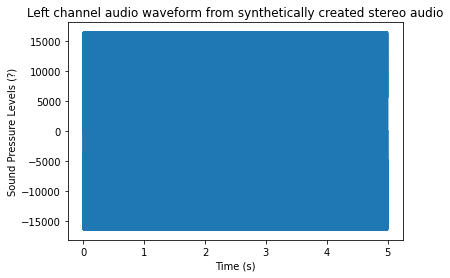

Left channel audio:


In [396]:
plt.plot(t_series,w_signal[0])
plt.xlabel('Time (s)')
plt.ylabel('Sound Pressure Levels (?)')
plt.title("Left channel audio waveform from synthetically created stereo audio")
plt.show()

print("Left channel audio:")
IPython.display.Audio(w_signal[0], rate=s_rate)

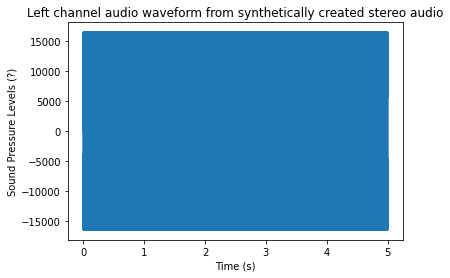

Right channel audio:


In [397]:
plt.plot(t_series,w_signal[1])
plt.xlabel('Time (s)')
plt.ylabel('Sound Pressure Levels (?)')
plt.title("Left channel audio waveform from synthetically created stereo audio")
plt.show()

print("Right channel audio:")
IPython.display.Audio(w_signal[0], rate=s_rate)

In [401]:
print(w_signal_transposed.shape)
delays = find_delays(w_signal_transposed) # This outputs average time delay of each waveform in samples
delays_t = delays/s_rate # Converts delays in samples to delays in seconds
print(delays)
print(delays_t)

(220544, 2)


ValueError: could not broadcast input array from shape (2,10000) into shape (2)

In [340]:
sens_pos = np.array([-0.15, 0.15]) # Defining distance of microphones from azimuth angle = 0 in metres
beam_pattern = [] # Creating empty array to store beam battern data
angles_tested = list(np.linspace(-np.pi/2,np.pi/2,36)) # Defining angle range tested and number of increments
for theta in angles_tested:
    steering_delay = arlpy.bf.steering_plane_wave(sens_pos,343,theta) # Computing steering delays for incoming planar wavefront for each sensor
    y = arlpy.bf.broadband(w_signal,s_rate,1000,steering_delay) # Performs beamforming in frequency domain and outputs steering direction
    beam_pattern.append(np.mean(y**2)) # Unsure why we raise beam pattern by a factor of 2 here
beam_pattern = np.array(beam_pattern)

plt.plot(angles_tested,control.mag2db(beam_pattern),'-D') # Converts magnitude to decibels (dB = 20log10(magnitude))
plt.xlim((-np.pi/2,np.pi/2))
plt.xlabel('Azimuth angle')
plt.ylabel('Power (dB)')
plt.title("Beam Pattern for 2 mic. ULA with 30cm spacing")
plt.show()

MemoryError: Unable to allocate 0 bytes for an array with shape (720049, 0, 1000) and data type complex128